In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
%matplotlib inline

In [2]:
#Next we will set the parameters of the genetic algorithm. Here, we will have 100 individuals
#each with a length of 50. The selection percentage will be 20% (keeping the top 20 
#individuals). The mutation will be set to be the inverse of the number of features, a common
#place to start for the mutation. This means that we expect one feature per child solution 
#to change. We will run the genetic algorithm for 200 generations
pop_size = 100
features = 50
selection = 0.2
mutation = 1./pop_size
generations = 200
num_parents = int(pop_size*selection)
num_children = pop_size - num_parents

In [3]:
#We will initialize the graph session and create the groud truth function, which we will use 
#to quickly calculate the fitness

# Start a graph session
sess = tf.Session()

# Create ground truth
truth = np.sin(2*np.pi*(np.arange(features, dtype=np.float32))/features)

# Initialize population array
population = tf.Variable(np.random.randn(pop_size, features), dtype=tf.float32)

In [4]:
#We can now craete the placeholders for the genetic algorithm. The placeholders are for the 
#ground truth and also for data that will change for every generation. Since we want the 
#crossover places between parents to change and the mutation probabilities/values to change,
#those will be the placeholders in our model
truth_ph = tf.placeholder(tf.float32, [1, features])
crossover_mat_ph = tf.placeholder(tf.float32, [num_children, features])
mutation_val_ph = tf.placeholder(tf.float32, [num_children, features])

In [5]:
#Now we will calculate the population fitness (negative mean squared error), and find the top
#performing individuals
fitness = -tf.reduce_mean(tf.square(tf.subtract(population, truth_ph)), 1)
top_vals, top_ind = tf.nn.top_k(fitness, k=pop_size)

In [6]:
#For results and plotting purposes, we also want to retrieve the best fit individual in the 
#population
best_val = tf.reduce_min(top_vals)
best_ind = tf.arg_min(top_vals, 0)
best_individual = tf.gather(population, best_ind)

Instructions for updating:
Use `argmin` instead


In [7]:
#Next, we sort the parent population and slice off the top performing individuals to make 
#them parents for the next generation 
population_sorted = tf.gather(population, top_ind)
parents = tf.slice(population_sorted, [0, 0], [num_parents, features])

In [8]:
#Now we will create the children by creating two parent matrices that are randomly shuffled.
#Then we multiple and add the parent matrices by the crossover matrix of 1s and zeros that we
#will generate each generation for the placeholders.

# Indices to shuffle-gather parents
rand_parent1_ix = np.random.choice(num_parents, num_children)
rand_parent2_ix = np.random.choice(num_parents, num_children)
# Gather parents by shuffled indices, expand back out to pop_size too
rand_parent1 = tf.gather(parents, rand_parent1_ix)
rand_parent2 = tf.gather(parents, rand_parent2_ix)
rand_parent1_sel = tf.multiply(rand_parent1, crossover_mat_ph)
rand_parent2_sel = tf.multiply(rand_parent2, tf.subtract(1., crossover_mat_ph))
children_after_sel = tf.add(rand_parent1_sel, rand_parent2_sel)

In [9]:
#The last steps are to mutate the children, which we will do by adding a random normal 
#account to approximately 1/feature fraction of entries in the children matrix and 
#concatenate this matrix back into the parent population

mutated_children = tf.add(children_after_sel, mutation_val_ph)

# Combine children and parents into new population
new_population = tf.concat(axis=0, values=[parents, mutated_children])

step = tf.group(population.assign(new_population))

init = tf.global_variables_initializer()
sess.run(init)

In [10]:
#Finally we loop through the generaions, recreating the random crossover and mutation for 
#matrices and updating the population each generation
for i in range(generations):
    # Create cross-over matrices for plugging in.
    crossover_mat = np.ones(shape=[num_children, features])
    crossover_point = np.random.choice(np.arange(1, features-1, step=1), num_children)
    for pop_ix in range(num_children):
        crossover_mat[pop_ix,0:crossover_point[pop_ix]]=0.
    # Generate mutation probability matrices
    mutation_prob_mat = np.random.uniform(size=[num_children, features])
    mutation_values = np.random.normal(size=[num_children, features])
    mutation_values[mutation_prob_mat >= mutation] = 0
    
    # Run GA step
    feed_dict = {truth_ph: truth.reshape([1, features]),
                 crossover_mat_ph: crossover_mat,
                 mutation_val_ph: mutation_values}
    step.run(feed_dict, session=sess)
    best_individual_val = sess.run(best_individual, feed_dict=feed_dict)
    
    if i % 5 == 0:
        best_fit = sess.run(best_val, feed_dict = feed_dict)
        print('Generation: {}, Best Fitness (lowest MSE): {:.2}'.format(i, -best_fit))

Generation: 0, Best Fitness (lowest MSE): 1.5
Generation: 5, Best Fitness (lowest MSE): 0.67
Generation: 10, Best Fitness (lowest MSE): 0.58
Generation: 15, Best Fitness (lowest MSE): 0.45
Generation: 20, Best Fitness (lowest MSE): 0.4
Generation: 25, Best Fitness (lowest MSE): 0.33
Generation: 30, Best Fitness (lowest MSE): 0.31
Generation: 35, Best Fitness (lowest MSE): 0.23
Generation: 40, Best Fitness (lowest MSE): 0.27
Generation: 45, Best Fitness (lowest MSE): 0.17
Generation: 50, Best Fitness (lowest MSE): 0.27
Generation: 55, Best Fitness (lowest MSE): 0.29
Generation: 60, Best Fitness (lowest MSE): 0.18
Generation: 65, Best Fitness (lowest MSE): 0.18
Generation: 70, Best Fitness (lowest MSE): 0.28
Generation: 75, Best Fitness (lowest MSE): 0.13
Generation: 80, Best Fitness (lowest MSE): 0.2
Generation: 85, Best Fitness (lowest MSE): 0.15
Generation: 90, Best Fitness (lowest MSE): 0.18
Generation: 95, Best Fitness (lowest MSE): 0.091
Generation: 100, Best Fitness (lowest MSE): 

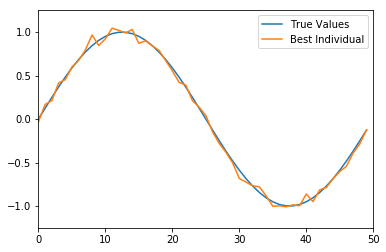

In [11]:
plt.plot(truth, label="True Values")
plt.plot(np.squeeze(best_individual_val), label="Best Individual")
plt.axis((0, features, -1.25, 1.25))
plt.legend(loc='upper right')
plt.show()